In [ ]:
import pandas as pd

# CSV 파일 불러오기
df = pd.read_csv("./data/목적별 국적별 입국_250708124220.csv")

# "소 계" 포함된 행 제거
df_cleaned = df[~df.apply(lambda row: row.astype(str).str.contains("소 계").any(), axis=1)]

# 결과 저장
df_cleaned.to_csv("./data/목적별_국적별_입국_소계제거.csv", index=False, encoding='cp949')


In [ ]:
import pandas as pd

# CSV 불러오기
df = pd.read_csv("./data/목적별_국적별_입국_소계제거.csv", encoding='cp949')



# 결측치 제거 또는 채우기
# df_cleaned = df_cleaned.dropna()       # ← 결측치 제거
df_cleaned = df_cleaned.fillna(0)        # ← 결측치를 0으로 대체

# 결과 저장
df_cleaned.to_csv("목적별_국적별_입국_소계제거_결측처리.csv", index=False, encoding='cp949')


In [ ]:
import pandas as pd

# 파일 경로
file_path = "./data/filtered_입국통계.csv"

# CSV 파일 읽기 (EUC-KR 인코딩)
df = pd.read_csv(file_path, encoding="cp949")

# 첫 번째 행(헤더처럼 쓰인 실제 데이터 행)에서 '성장률', '구성비' 포함된 열 인덱스 찾기
header_row = df.iloc[0]
columns_to_drop = [i for i, val in enumerate(header_row) if '성장률' in str(val) or '구성비' in str(val)]

# 해당 열 제거
df_cleaned = df.drop(df.columns[columns_to_drop], axis=1)

# 첫 번째 행 제거 (실제 데이터 시작)
df_cleaned = df_cleaned.drop(index=0).reset_index(drop=True)

# 결과 저장
df_cleaned.to_csv("./data/정제된_입국통계_인원만.csv", index=False, encoding="cp949")


In [ ]:
import pandas as pd

# CSV 파일 불러오기
df = pd.read_csv("./data/정제된_입국통계_인원만.csv", encoding="cp949")

# "소 계" 포함된 행 제거
df_filtered = df[~df.apply(lambda row: row.astype(str).str.contains("소 계").any(), axis=1)]

# 결과 저장
df_filtered.to_csv("./data/소계제거_입국통계.csv", index=False, encoding="cp949")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# 1. 데이터 로딩 및 전처리
df = pd.read_csv("./data/목적별 국적별 입국(전처리).csv", encoding="cp949")
df = df.melt(id_vars=["국적", "목적"], var_name="월", value_name="입국자수")
df["월"] = pd.to_datetime(df["월"], format="%Y년%m월")
df = df.sort_values("월")

# 2. 관광 목적 필터링
df = df[df["목적"] == "관광"].reset_index(drop=True)

# 3. 파생 변수 추가
df["연도"] = df["월"].dt.year
df["월_숫자"] = df["월"].dt.month
df["계절"] = df["월"].dt.month % 12 // 3  # 0~3 (겨울~가을)
df["전월입국자수"] = df["입국자수"].shift(1)
df["전년동월입국자수"] = df["입국자수"].shift(12)
df["전월증감률"] = df["입국자수"].pct_change().shift(1)
df["전년증감률"] = (df["입국자수"] - df["입국자수"].shift(12)) / df["입국자수"].shift(12)
df["이동평균"] = df["입국자수"].rolling(window=3).mean().shift(1)

# 4. 결측치 제거
df_model = df.dropna()
df_model = df_model.replace([np.inf, -np.inf], np.nan).dropna()


# 5. 특성과 타겟 분리
features = ["연도", "월_숫자", "계절", "전월입국자수", "전년동월입국자수",
            "전월증감률", "전년증감률", "이동평균"]
X = df_model[features]
y = df_model["입국자수"]

# 6. 최근 6개월을 테스트셋으로 분할
X_train, X_test = X[:-6], X[-6:]
y_train, y_test = y[:-6], y[-6:]

# 7. 모델 학습
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 8. 예측 + 음수 방지
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, 0, None)

# 9. 성능 평가
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# 10. 시각화
plt.figure(figsize=(10, 5))
plt.bar(range(6), y_test.values, label="실제값", alpha=0.6)
plt.plot(range(6), y_pred, color='orange', label="예측값 (XGBoost)", marker='o', linewidth=2)
plt.title(f"관광 목적 입국자 수 예측 (XGBoost 개선모델)\nRMSE: {rmse:.0f}")
plt.xlabel("테스트 샘플 (최근 6개월)")
plt.ylabel("입국자 수")
plt.xticks(range(6), labels=[f"{i+1}번째" for i in range(6)])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# 1. 데이터 로딩 및 전처리
df = pd.read_csv("./data/목적별 국적별 입국(전처리).csv", encoding="cp949")
df = df.melt(id_vars=["국적", "목적"], var_name="월", value_name="입국자수")
df["월"] = pd.to_datetime(df["월"], format="%Y년%m월")
df = df.sort_values("월")

# 2. 관광 목적 필터링
df = df[df["목적"] == "관광"].reset_index(drop=True)

# 3. 파생 변수 추가
df["연도"] = df["월"].dt.year
df["월_숫자"] = df["월"].dt.month
df["계절"] = df["월"].dt.month % 12 // 3
df["전월입국자수"] = df["입국자수"].shift(1)
df["전년동월입국자수"] = df["입국자수"].shift(12)
df["전월증감률"] = df["입국자수"].pct_change().shift(1)
df["전년증감률"] = (df["입국자수"] - df["입국자수"].shift(12)) / df["입국자수"].shift(12)
df["이동평균"] = df["입국자수"].rolling(window=3).mean().shift(1)

# 4. 결측치 및 무한값 제거
df_model = df.replace([np.inf, -np.inf], np.nan).dropna().copy()

# 5. 특성 설정
features = ["연도", "월_숫자", "계절", "전월입국자수", "전년동월입국자수",
            "전월증감률", "전년증감률", "이동평균"]
df_model["월_숫자"] = df_model["월_숫자"].astype(int)
df_model["계절"] = df_model["계절"].astype(int)

X = df_model[features]
y = df_model["입국자수"]
dates = df_model["월"]

# 6. 최근 6개월 분할
X_train, X_test = X[:-6], X[-6:]
y_train, y_test = y[:-6], y[-6:]
dates_train, dates_test = dates[:-6], dates[-6:]

# 7. 모델 학습
model = XGBRegressor(n_estimators=50, random_state=42)
model.fit(X_train, y_train)

# 8. 예측 및 음수 방지
y_pred = np.clip(model.predict(X_test), 0, None)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# 9. 전체 시계열 + 예측 시각화
plt.figure(figsize=(14, 6))
plt.plot(dates_train, y_train, label="실제값 (학습)", color='blue')
plt.plot(dates_test, y_test, label="실제값 (테스트)", color='red', linestyle='--')
plt.plot(dates_test, y_pred, label="예측값 (XGBoost)", color='orange', marker='o')
plt.title(f"관광 목적 입국자 수 전체 추이 + 6개월 예측 (XGBoost)\nRMSE: {rmse:.0f}")
plt.xlabel("월")
plt.ylabel("입국자 수")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 10. 최근 2년 확대 시각화
plt.figure(figsize=(12, 5))
mask = dates >= pd.to_datetime("2023-01-01")
plt.plot(dates[mask], y[mask], label="실제값 (최근 2년)", color='blue')
plt.plot(dates_test, y_test, label="실제값 (최근 6개월)", color='red', linestyle='--')
plt.plot(dates_test, y_pred, label="예측값 (XGBoost)", color='orange', marker='o')
plt.title(f"[확대] 최근 2년 입국자 수 추이 + 6개월 예측")
plt.xlabel("월")
plt.ylabel("입국자 수")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# 1. 데이터 로딩 및 전처리
df = pd.read_csv("./data/목적별 국적별 입국(전처리).csv", encoding="cp949")
df = df.melt(id_vars=["국적", "목적"], var_name="월", value_name="입국자수")
df["월"] = pd.to_datetime(df["월"], format="%Y년%m월")
df = df.sort_values("월")

# 2. 관광 목적 필터링
df = df[df["목적"] == "관광"].reset_index(drop=True)

# 3. 파생 변수 추가
df["연도"] = df["월"].dt.year
df["월_숫자"] = df["월"].dt.month
df["계절"] = df["월"].dt.month % 12 // 3
df["전월입국자수"] = df["입국자수"].shift(1)
df["전년동월입국자수"] = df["입국자수"].shift(12)
df["전월증감률"] = df["입국자수"].pct_change().shift(1)
df["전년증감률"] = (df["입국자수"] - df["입국자수"].shift(12)) / df["입국자수"].shift(12)
df["이동평균"] = df["입국자수"].rolling(window=3).mean().shift(1)

# 4. 결측치 제거
df_model = df.replace([np.inf, -np.inf], np.nan).dropna().copy()

# 5. 학습 데이터 준비
features = ["연도", "월_숫자", "계절", "전월입국자수", "전년동월입국자수",
            "전월증감률", "전년증감률", "이동평균"]
X = df_model[features]
y = df_model["입국자수"]
dates = df_model["월"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test = X_scaled[:-6], X_scaled[-6:]
y_train, y_test = y[:-6], y[-6:]
dates_train, dates_test = dates[:-6], dates[-6:]

# 6. XGBoost 모델 학습
model = XGBRegressor(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# 7. 예측
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# 8. 전체 시계열 + 예측 시각화
plt.figure(figsize=(14, 6))
plt.plot(dates_train, y_train, label="실제값 (학습)", color='blue')
plt.plot(dates_test, y_test, label="실제값 (테스트)", color='red', linestyle='--')
plt.plot(dates_test, y_pred, label="예측값 (XGBoost)", color='orange', marker='o')
plt.title(f"관광 목적 입국자 수 전체 추이 + 6개월 예측 (XGBoost)\nRMSE: {rmse:.0f}")
plt.xlabel("월")
plt.ylabel("입국자 수")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

# 9. 최근 2년 확대 시각화
plt.figure(figsize=(13, 5))
recent_mask = dates >= pd.to_datetime("2023-01-01")
plt.plot(dates[recent_mask], y[recent_mask], label="실제값 (최근 2년)", color='blue')
plt.plot(dates_test, y_test, label="실제값 (최근 6개월)", color='red', linestyle='--')
plt.plot(dates_test, y_pred, label="예측값 (XGBoost)", color='orange', marker='o')
plt.title("[확대] 최근 2년 입국자 수 추이 + 6개월 예측")
plt.xlabel("월")
plt.ylabel("입국자 수")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt

# 1. 데이터 로딩
df = pd.read_csv("./data/목적별 국적별 입국(전처리).csv", encoding="cp949")
df = df.melt(id_vars=["국적", "목적"], var_name="월", value_name="입국자수")
df["월"] = pd.to_datetime(df["월"], format="%Y년%m월")
df = df.sort_values("월")

# 2. 관광 목적 필터링
df = df[df["목적"] == "관광"].reset_index(drop=True)

# 3. 외생 변수 생성
df["연도"] = df["월"].dt.year
df["월_숫자"] = df["월"].dt.month
df["계절"] = df["월"].dt.month % 12 // 3
df["전월입국자수"] = df["입국자수"].shift(1)
df["전년동월입국자수"] = df["입국자수"].shift(12)
df["전월증감률"] = df["입국자수"].pct_change().shift(1)
df["전년증감률"] = (df["입국자수"] - df["입국자수"].shift(12)) / df["입국자수"].shift(12)
df["이동평균"] = df["입국자수"].rolling(window=3).mean().shift(1)
df["코로나영향"] = df["월"].apply(lambda x: 1 if pd.Timestamp("2020-01") <= x <= pd.Timestamp("2021-12") else 0)
df = df.replace([np.inf, -np.inf], np.nan).dropna().copy()

# 4. Prophet 포맷
df_prophet = df[["월", "입국자수", "전월입국자수", "전년동월입국자수", "전월증감률", "전년증감률", "이동평균", "코로나영향"]].rename(columns={"월": "ds", "입국자수": "y"})

# 5. Prophet 모델 정의 + 외생 변수 추가
model = Prophet(yearly_seasonality=True, changepoint_prior_scale=0.05)
model.add_regressor("전월입국자수")
model.add_regressor("전년동월입국자수")
model.add_regressor("전월증감률")
model.add_regressor("전년증감률")
model.add_regressor("이동평균")
model.add_regressor("코로나영향")

# 6. 모델 학습
model.fit(df_prophet)

# 7. 미래 예측용 데이터 구성
future = model.make_future_dataframe(periods=6, freq="MS")
future = future.merge(df_prophet.drop(columns="y"), on="ds", how="left")
for col in ["전월입국자수", "전년동월입국자수", "전월증감률", "전년증감률", "이동평균"]:
    future[col] = future[col].fillna(method='ffill')
future["코로나영향"] = future["ds"].apply(lambda x: 1 if pd.Timestamp("2020-01") <= x <= pd.Timestamp("2021-12") else 0)

# 8. 예측 수행
forecast = model.predict(future)

# 9. 시각화
plt.figure(figsize=(14, 6))
plt.bar(df_prophet["ds"], df_prophet["y"], label="실제값", color="blue", alpha=0.6)
plt.plot(forecast["ds"], forecast["yhat"], label="예측값 (Prophet+외생변수)", color="orange", linewidth=2)
plt.axvline(df_prophet["ds"].max(), color="gray", linestyle="--", label="예측 시작")
plt.title("관광 목적 입국자 수 전체 추이 + 6개월 예측 (Prophet 고급형)")
plt.xlabel("월")
plt.ylabel("입국자 수")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


17:55:04 - cmdstanpy - INFO - Chain [1] start processing
17:55:05 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\Admin\AppData\Local\Temp\ipykernel_2824\807195498.py:64: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_2824\807195498.py:64: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_2824\807195498.py:64: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_2824\807195498.py:64: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_2824\807195498.py:64: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_2824\807195498.py:64

C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50808 (\N{HANGUL SYLLABLE OE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49373 (\N{HANGUL SYLLABLE SAENG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48320 (\N{HANGUL SYLLABLE BYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Admin\anaconda3\envs\ml-dl-nlp\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from cur

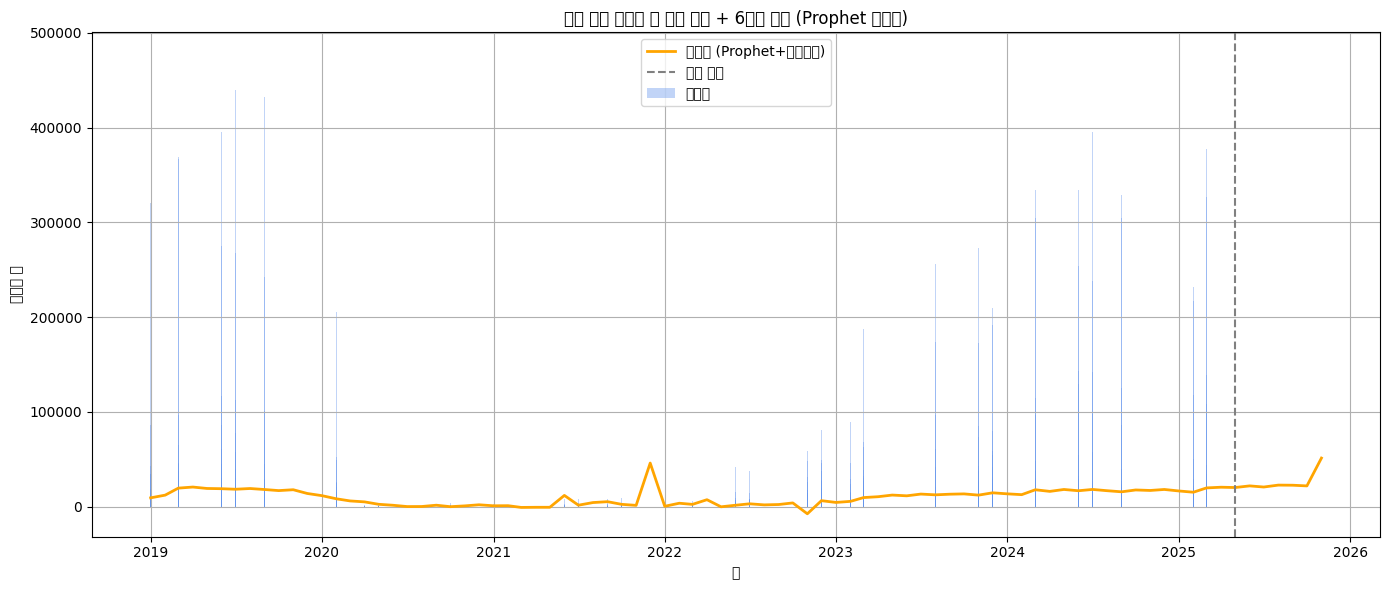

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

# 1. 데이터 불러오기
df = pd.read_csv("./data/목적별 국적별 입국(전처리).csv", encoding="cp949")
df = df.melt(id_vars=["국적", "목적"], var_name="월", value_name="입국자수")
df["월"] = pd.to_datetime(df["월"], format="%Y년%m월")
df = df[df["목적"] == "관광"].sort_values("월").reset_index(drop=True)

# 2. Prophet 입력 형식 변환
df_prophet = df[["월", "입국자수"]].rename(columns={"월": "ds", "입국자수": "y"})

# 3. 외생 변수 추가 (예측력 향상용)
df_prophet["lag1"] = df_prophet["y"].shift(1)
df_prophet["lag12"] = df_prophet["y"].shift(12)
df_prophet = df_prophet.dropna().reset_index(drop=True)

# 4. Prophet 모델 정의 및 외생변수 등록
model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.3
)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_regressor("lag1")
model.add_regressor("lag12")

# 5. 모델 학습
model.fit(df_prophet)

# 6. 예측 데이터프레임 생성 (미래 6개월)
future = model.make_future_dataframe(periods=6, freq='MS')

# 7. 외생변수 lag 채우기
last_lag1 = df_prophet["y"].iloc[-1]
last_lag12 = df_prophet["y"].shift(12).iloc[-6:].reset_index(drop=True)

future["lag1"] = pd.concat([
    df_prophet["lag1"], 
    pd.Series([last_lag1]*6)
], ignore_index=True)

future["lag12"] = pd.concat([
    df_prophet["lag12"], 
    last_lag12
], ignore_index=True)

# 8. 예측
forecast = model.predict(future)

# 9. 시각화
plt.figure(figsize=(14, 6))
plt.bar(df_prophet["ds"], df_prophet["y"], label="실제값", alpha=0.4, color='cornflowerblue')
plt.plot(forecast["ds"], forecast["yhat"], color='orange', label="예측값 (Prophet+외생변수)", linewidth=2)
plt.axvline(x=df_prophet["ds"].iloc[-1], color='gray', linestyle='--', label="예측 시작")
plt.title("관광 목적 입국자 수 전체 추이 + 6개월 예측 (Prophet 고급형)")
plt.xlabel("월")
plt.ylabel("입국자 수")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\Admin\AppData\Local\Temp\ipykernel_2824\3822963036.py:61: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_2824\3822963036.py:61: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_2824\3822963036.py:61: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_2824\3822963036.py:61: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_2824\3822963036.py:61: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_2824\3822963036.py:61: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from current font.
  plt.tight_layout()
C:\Us

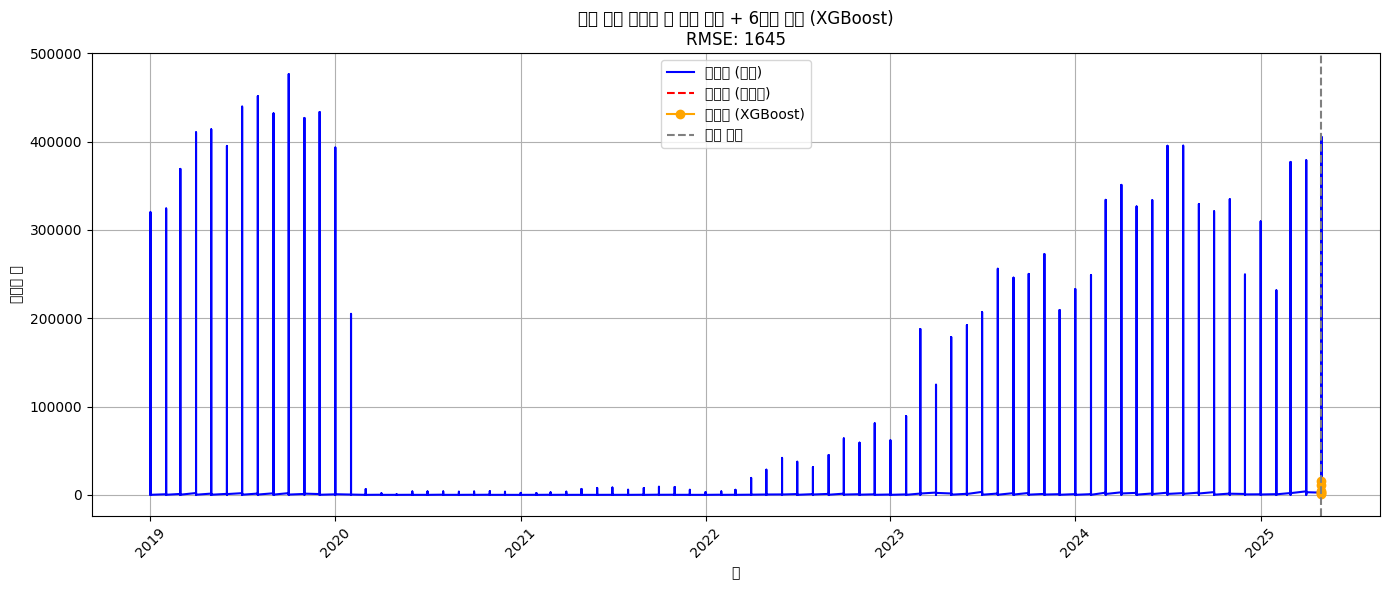

C:\Users\Admin\AppData\Local\Temp\ipykernel_2824\3822963036.py:77: UserWarning: Glyph 50900 (\N{HANGUL SYLLABLE WEOL}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_2824\3822963036.py:77: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_2824\3822963036.py:77: UserWarning: Glyph 44397 (\N{HANGUL SYLLABLE GUG}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_2824\3822963036.py:77: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_2824\3822963036.py:77: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_2824\3822963036.py:77: UserWarning: Glyph 54869 (\N{HANGUL SYLLABLE HWAG}) missing from current font.
  plt.tight_layout()
C:\Us

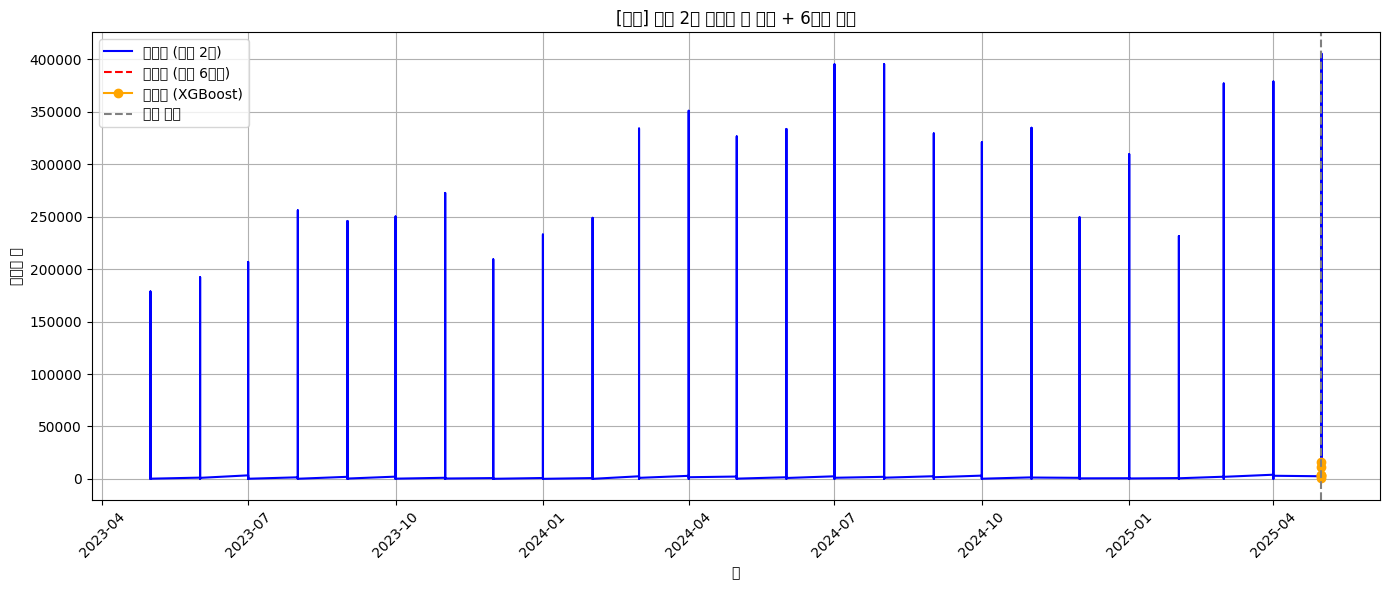

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# 1. 데이터 로딩
df = pd.read_csv("./data/목적별 국적별 입국(전처리).csv", encoding="cp949")
df = df.melt(id_vars=["국적", "목적"], var_name="월", value_name="입국자수")
df["월"] = pd.to_datetime(df["월"], format="%Y년%m월")
df = df.sort_values("월")

# 2. 관광 목적 필터링
df = df[df["목적"] == "관광"].reset_index(drop=True)

# 3. 파생변수
df["연도"] = df["월"].dt.year
df["월_숫자"] = df["월"].dt.month
df["계절"] = df["월_숫자"] % 12 // 3
df["lag_1"] = df["입국자수"].shift(1)
df["lag_12"] = df["입국자수"].shift(12)
df["증감률_1"] = df["입국자수"].pct_change().shift(1)
df["증감률_12"] = (df["입국자수"] - df["입국자수"].shift(12)) / df["입국자수"].shift(12)
df["이동평균_3"] = df["입국자수"].rolling(3).mean().shift(1)

# 4. 결측 제거
df_model = df.dropna().replace([np.inf, -np.inf], np.nan).dropna().copy()

# 5. 학습용 특성
features = ["연도", "월_숫자", "계절", "lag_1", "lag_12", "증감률_1", "증감률_12", "이동평균_3"]
X = df_model[features]
y = df_model["입국자수"]
dates = df_model["월"]

# 6. 데이터 분할 (최근 6개월 테스트)
X_train, X_test = X[:-6], X[-6:]
y_train, y_test = y[:-6], y[-6:]
dates_train, dates_test = dates[:-6], dates[-6:]

# 7. XGBoost 학습
model = XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# 8. 예측
y_pred = model.predict(X_test)
y_pred = np.clip(y_pred, 0, None)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# 9. 전체 시각화
plt.figure(figsize=(14, 6))
plt.plot(dates_train, y_train, label="실제값 (학습)", color="blue")
plt.plot(dates_test, y_test, label="실제값 (테스트)", color="red", linestyle="--")
plt.plot(dates_test, y_pred, label="예측값 (XGBoost)", color="orange", marker="o")
plt.axvline(dates_test.iloc[0], color="gray", linestyle="--", label="예측 시작")
plt.title(f"관광 목적 입국자 수 전체 추이 + 6개월 예측 (XGBoost)\nRMSE: {rmse:.0f}")
plt.xlabel("월")
plt.ylabel("입국자 수")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 10. 최근 2년 확대 시각화
plt.figure(figsize=(14, 6))
recent_mask = dates >= (dates.max() - pd.DateOffset(years=2))
plt.plot(dates[recent_mask], y[recent_mask], label="실제값 (최근 2년)", color="blue")
plt.plot(dates_test, y_test, label="실제값 (최근 6개월)", color="red", linestyle="--")
plt.plot(dates_test, y_pred, label="예측값 (XGBoost)", color="orange", marker="o")
plt.axvline(dates_test.iloc[0], color="gray", linestyle="--", label="예측 시작")
plt.title("[확대] 최근 2년 입국자 수 추이 + 6개월 예측")
plt.xlabel("월")
plt.ylabel("입국자 수")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
